### 0.1°网格内EBA总比例

#### 存储数据

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rioxarray as rxr
import scipy.stats as stats
import pandas as pd
import seaborn as sns


if __name__ == '__main__':
    EBA_Dir = 'D:/Landcover/CA_forest_lead_tree_species_2019/wildfire_clip_0005/CA_forest_lead_tree_species_EBA_WGS84_0005_fireclip.tif'
    spei_Dir = 'D:/ERA5/ERA5land_monthly_2000_2023_5eco_extent/spei_pro/spei_2402/ERA5landn_climgrid_lowres_spei_5eco_spei_gamma_03.nc'
    BA23_Dir = 'D:/Wildfire/23Canandafire/raw_Jan2Nov_BA/BA_2023_Jan2Nov_5eco_0005degree.tif'
    BA20_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2020_annual_WGS84_5eco_0005degree.tif'
    BA21_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2021_annual_WGS84_5eco_0005degree.tif'
    BA22_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2022_annual_WGS84_5eco_0005degree.tif'

    BA23_ds = rxr.open_rasterio(BA23_Dir)
    BA20_ds = rxr.open_rasterio(BA20_Dir)
    BA21_ds = rxr.open_rasterio(BA21_Dir)
    BA22_ds = rxr.open_rasterio(BA22_Dir)
    EBA_ds = rxr.open_rasterio(EBA_Dir)
    spei_ds = xr.open_dataset(spei_Dir)

    spei = spei_ds.sel(lat=spei_ds.lat[spei_ds.lat > 47])
    spei = spei.spei_gamma_03
    spei23 = spei.sel(time=slice('2023-04-01', '2023-10-01'))
    spei20 = spei.sel(time=slice('2020-04-01', '2020-10-01'))
    spei21 = spei.sel(time=slice('2021-04-01', '2021-10-01'))
    spei22 = spei.sel(time=slice('2022-04-01', '2022-10-01'))
    spei23 = spei23.mean(dim='time')
    spei20 = spei20.mean(dim='time')
    spei21 = spei21.mean(dim='time')
    spei22 = spei22.mean(dim='time')

    BA23 = BA23_ds.squeeze()
    BA20 = BA20_ds.squeeze()
    BA21 = BA21_ds.squeeze()
    BA22 = BA22_ds.squeeze()
    EBA = EBA_ds.squeeze()

    # 将BA数据中大于0的值都替换为1
    BA23 = BA23.where(BA23 <= 0, 1)
    BA20 = BA20.where(BA20 <= 0, 1)
    BA21 = BA21.where(BA21 <= 0, 1)
    BA22 = BA22.where(BA22 <= 0, 1)
    
    # 修改BA坐标轴名称
    BA23 = BA23.rename({'x': 'lon', 'y': 'lat'})
    BA20 = BA20.rename({'x': 'lon', 'y': 'lat'})
    BA21 = BA21.rename({'x': 'lon', 'y': 'lat'})
    BA22 = BA22.rename({'x': 'lon', 'y': 'lat'})

    # 获取spei的行列数
    rows = spei23.shape[0]
    cols = spei23.shape[1]
    
    c_res = 0.1
    h_res = 0.005
    ratio = int(c_res/h_res)
    
    EBA_ls_his = []
    EBA_23 = []
    spei_ls_his = []
    spei_23 = []
    BA_23 = []
    BA_ls_his = []
    # 遍历每个像元
    for i in range(rows):
        for j in range(cols):
            # spei23的值
            spei23_value = spei23[i, j].values
            spei22_value = spei22[i, j].values
            spei21_value = spei21[i, j].values
            spei20_value = spei20[i, j].values
            # 获取高分辨率数据范围
            EBA_cell = EBA[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_23_cell = BA23[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_22_cell = BA22[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_21_cell = BA21[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_20_cell = BA20[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values

            # 判断这个格点是否出现过火灾
            if BA_23_cell.max() > 0:
                # 筛选出该格点中发生火灾的位置的EBA值
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_23_cell.flatten() > 0]
                # 删除nan值
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                # 统计总的BA fraction
                cell_BA_fraction = BA_23_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 添加到列表中
                EBA_23.append(cell_EBA_fraction)
                spei_23.append(spei23_value)
                BA_23.append(cell_BA_fraction)

            elif BA_22_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_22_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                # 统计总的BA fraction
                cell_BA_fraction = BA_22_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei22_value)
                BA_ls_his.append(cell_BA_fraction)

            elif BA_21_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_21_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                # 统计总的BA fraction
                cell_BA_fraction = BA_21_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei21_value)
                BA_ls_his.append(cell_BA_fraction)

            elif BA_20_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_20_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                # 统计总的BA fraction
                cell_BA_fraction = BA_20_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei20_value)
                BA_ls_his.append(cell_BA_fraction)

    # 将列表转换为数组
    EBA_23 = np.array(EBA_23)
    spei_23 = np.array(spei_23)
    BA_23 = np.array(BA_23)
    EBA_ls_his = np.array(EBA_ls_his)
    spei_ls_his = np.array(spei_ls_his)
    BA_ls_his = np.array(BA_ls_his)

    # 输出是否存在nan值
    print(np.isnan(EBA_23).any())
    print(np.isnan(spei_23).any())
    print(np.isnan(EBA_ls_his).any())
    print(np.isnan(spei_ls_his).any())
    print(np.isnan(BA_23).any())
    print(np.isnan(BA_ls_his).any())
    print(len(EBA_23), len(spei_23))
    print(len(EBA_ls_his), len(spei_ls_his))
    print(len(BA_23), len(BA_ls_his))

    # 剔除nan值
    EBA_23 = EBA_23[~np.isnan(spei_23)]
    BA_23 = BA_23[~np.isnan(spei_23)]
    spei_23 = spei_23[~np.isnan(spei_23)]
    EBA_ls_his = EBA_ls_his[~np.isnan(spei_ls_his)]
    BA_ls_his = BA_ls_his[~np.isnan(spei_ls_his)]
    spei_ls_his = spei_ls_his[~np.isnan(spei_ls_his)]  
    
    # 创建dataframe
    df_23 = pd.DataFrame({'EBA': EBA_23, 'spei': spei_23, 'BA': BA_23})
    df_his = pd.DataFrame({'EBA': EBA_ls_his, 'spei': spei_ls_his, 'BA': BA_ls_his})
    # 导出为csv
    df_23.to_csv('D:/Documents/outfile/spei_EBA_2023.csv', index=False)
    df_his.to_csv('D:/Documents/outfile/spei_EBA_his.csv', index=False)
    

    


False
True
False
True
False
False
7827 7827
6190 6190
7827 6190


#### spei-EBA 绘图

C:\Users\Administrator\AppData\Local\Temp\ipykernel_49524\2607650243.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_23 = np.array(df_23.groupby('spei')['EBA'].mean())
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49524\2607650243.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_23_p25 = np.array(df_23.groupby('spei')['EBA'].quantile(0.25))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49524\2607650243.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

[0.18278109 0.19999413 0.20683781 0.21270386 0.18260232 0.14542934
 0.10674071 0.06403951 0.07883811 0.03972452 0.04612757 0.09065639
 0.0588194  0.03973302 0.01827338 0.07101184 0.02208968 0.01785974
 0.04194489 0.02897068 0.0419999  0.02622872 0.04303779 0.06658151
 0.06026009 0.04683303 0.03984164 0.04479025 0.03937026 0.04659102
 0.03151992 0.05067594 0.06107058 0.05302203 0.06194163 0.05109968
 0.06564158 0.08316368 0.03181996 0.01651657 0.05281226 0.06964815
 0.01636292 0.00441736 0.03348546 0.01532191 0.01907225 0.00999022
 0.00358532 0.00979109]
[-3.00000000e+00 -2.90000000e+00 -2.80000000e+00 -2.70000000e+00
 -2.60000000e+00 -2.50000000e+00 -2.40000000e+00 -2.30000000e+00
 -2.20000000e+00 -2.10000000e+00 -2.00000000e+00 -1.90000000e+00
 -1.80000000e+00 -1.70000000e+00 -1.60000000e+00 -1.50000000e+00
 -1.40000000e+00 -1.30000000e+00 -1.20000000e+00 -1.10000000e+00
 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -

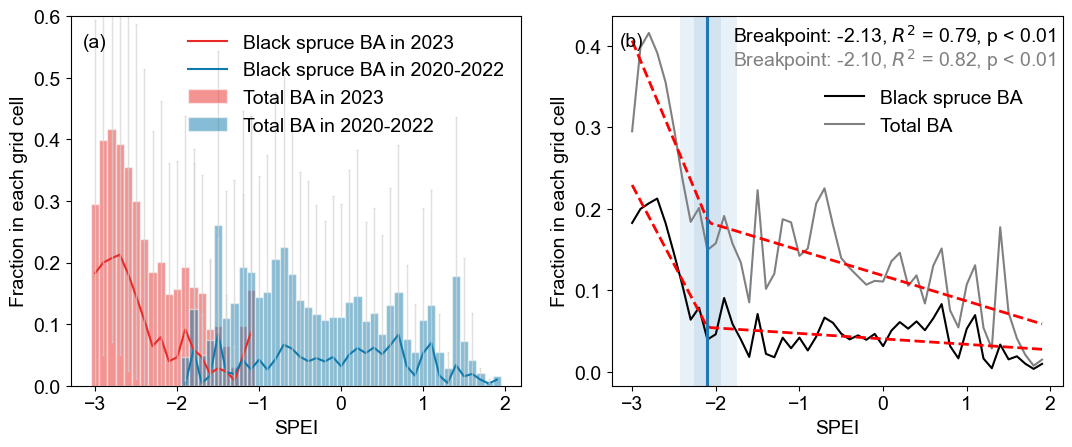

In [1]:
import xarray as xr
import piecewise_regression as pice
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.colors as colors


if __name__ == '__main__':
    df_23 = pd.read_csv('D:/Documents/outfile/spei_EBA_2023.csv')
    df_his = pd.read_csv('D:/Documents/outfile/spei_EBA_his.csv')

    spei_23 = np.array(df_23['spei'])
    EBA_23 = np.array(df_23['EBA'])
    spei_ls_his = np.array(df_his['spei'])
    EBA_ls_his = np.array(df_his['EBA'])

    # 对数据进行分组统计
    df_23['spei'] = pd.cut(df_23['spei'], bins=np.arange(-3, -0.9, 0.1))
    df_his['spei'] = pd.cut(df_his['spei'], bins=np.arange(-2, 2.1, 0.1))

   
    # 绘制不同spei区间的EBA均值
    X_23 = np.arange(-3, -1, 0.1)
    Y_23 = np.array(df_23.groupby('spei')['EBA'].mean())
    Y_23_p25 = np.array(df_23.groupby('spei')['EBA'].quantile(0.25))
    Y_23_p75 = np.array(df_23.groupby('spei')['EBA'].quantile(0.75))

    X_his = np.arange(-2, 2, 0.1)
    Y_his = np.array(df_his.groupby('spei')['EBA'].mean())
    Y_his_p25 = np.array(df_his.groupby('spei')['EBA'].quantile(0.25))
    Y_his_p75 = np.array(df_his.groupby('spei')['EBA'].quantile(0.75))

    # 不同spei区间的BA均值
    Y_BA_23 = np.array(df_23.groupby('spei')['BA'].mean())
    Y_BA_his = np.array(df_his.groupby('spei')['BA'].mean())
    Y_BA_23_std = np.array(df_23.groupby('spei')['BA'].std())
    Y_BA_his_std = np.array(df_his.groupby('spei')['BA'].std())

    
    

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap
    trunc_cmap = truncate_colormap(plt.get_cmap("Reds"), 0.2, 0.8)
    trunc_cmap1 = truncate_colormap(plt.get_cmap("Blues"), 0.2, 0.8)

    # 线性拟合
    #linear_fit_23 = np.polyfit(spei_23, EBA_23, 1)
    #linear_fit_his = np.polyfit(spei_ls_his, EBA_ls_his, 1)
    #y_values_23 = np.polyval(linear_fit_23, X_23)
    #y_values_his = np.polyval(linear_fit_his, X_his)

    # 字体字号，arial，14
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = 14

    error_kw1 = {
        'ecolor': 'lightgrey',        # 误差条颜色
        'elinewidth': 1,         # 误差条线宽
        'capsize': 0.5,            # 误差条帽子大小
        #'capthick': 2,           # 误差条帽子线宽
        'alpha': 0.7   
    }

    error_kw2 = {
        'ecolor': '#0F7AAC',        # 误差条颜色
        'elinewidth': 1,         # 误差条线宽
        'capsize': 0.5,            # 误差条帽子大小
        #'capthick': 2,           # 误差条帽子线宽
        'alpha': 0.7   
    }
    # 1行2列
    fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
    # 绘制密度散点图
    #sns.kdeplot(x=spei_23, y=EBA_23, fill=True, cmap=trunc_cmap, alpha=0.5, ax=ax[0])
    #sns.kdeplot(x=spei_ls_his, y=EBA_ls_his, fill=True, cmap=trunc_cmap1, alpha=0.5, ax=ax[0])
    # 绘制中位数
    ax[0].plot(X_23, Y_23, color='#E92A28', linestyle='-', label='Black spruce BA in 2023')
    ax[0].plot(X_his, Y_his, color='#0F7AAC', linestyle='-', label='Black spruce BA in 2020-2022')

    # 在底部绘制BA中位数的柱状图,bar宽度0.1
    ax[0].bar(X_23, np.array(Y_BA_23), color='#E92A28', edgecolor='white', width=0.1, alpha=0.5, label='Total BA in 2023', yerr=Y_BA_23_std, error_kw=error_kw1)
    ax[0].bar(X_his, np.array(Y_BA_his), color='#0F7AAC', edgecolor='white', width=0.1, alpha=0.5, label='Total BA in 2020-2022', yerr=Y_BA_his_std, error_kw=error_kw1)
    ax[0].set_ylabel('Fraction in each grid cell')
    ax[0].set_ylim(0, 0.6)
    # 添加图例
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('SPEI')
    
    # 分段回归
    df_23 = pd.read_csv('D:/Documents/outfile/spei_EBA_2023.csv')
    df_his = pd.read_csv('D:/Documents/outfile/spei_EBA_his.csv')
    df_all = pd.concat([df_23, df_his])
    # 对数据进行分组统计
    df_all['spei'] = pd.cut(df_all['spei'], bins=np.arange(-3, 2.1, 0.1))
    # 绘制不同spei区间的EBA均值
    X_all = np.arange(-3, 2, 0.1)
    Y_all = df_all.groupby('spei')['EBA'].mean()
    Y_all_BA = df_all.groupby('spei')['BA'].mean()
   
    Y_all_u25 = df_all.groupby('spei')['EBA'].quantile(0.25)
    Y_all_l75 = df_all.groupby('spei')['EBA'].quantile(0.75)
    Y_all_BA_u25 = df_all.groupby('spei')['BA'].quantile(0.25)
    Y_all_BA_l75 = df_all.groupby('spei')['BA'].quantile(0.75)
    Y_all_value = np.array(Y_all)
    Y_all_BA_value = np.array(Y_all_BA)
    print(Y_all_value)
    print(X_all)
    # 子图2中绘制
    ax[1].plot(X_all, Y_all, color='black', linestyle='-', label='Black spruce BA')
    ax[1].plot(X_all, Y_all_BA, color='grey', linestyle='-', label='Total BA')
    # picewise regression
    pw_fit = pice.Fit(X_all, Y_all_value, n_breakpoints=1)
    pw_fit.summary()
    pw_fit.plot_fit(color="red", linewidth=2, linestyle="--")
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()

    pw_fit2 = pice.Fit(X_all, Y_all_BA_value, n_breakpoints=1)
    pw_fit2.summary()
    pw_fit2.plot_fit(color="red", linewidth=2, linestyle="--")
    pw_fit2.plot_breakpoints()
    pw_fit2.plot_breakpoint_confidence_intervals()
    
   
    
    plt.xlabel('SPEI')
    plt.ylabel('Fraction in each grid cell')
    # 添加标签Breakpoint: -1.58
    plt.text(-1.8, 0.405, 'Breakpoint: -2.13, ${R^{2}}$ = 0.79, p < 0.01', fontsize=14)
    # 添加标签R2 = 0.4, p < 0.001，r2用上标
    plt.text(-1.8, 0.375, 'Breakpoint: -2.10, ${R^{2}}$ = 0.82, p < 0.01', fontsize=14, color='grey')
    # 添加图例,自定义图例位置
    plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.95, 0.85))

    # 添加标签
    ax[0].text(-3.15, 0.55, '(a)')
    ax[1].text(-3.15, 0.4, '(b)')
    #plt.savefig('D:/Documents/Fig/SPEI_EBA_piecewise2.png', dpi=300, bbox_inches='tight')
    
    # 添加拟合直线,虚线
    #ax1.plot(X_23, y_values_23, color='#E92A28', linestyle='--')
    #ax1.plot(X_his, y_values_his, color='#0F7AAC', linestyle='--')

    # 右侧y轴添加刻度和标签
    #ax2 = ax1.twinx()
    #yticks = [0, 0.2, 0.4, 0.6]#, 0.8, 1]
    #ax2.set_ylim(0, 0.6)
    #ax2.set_yticks(yticks)
    #ax2.set_ylabel('Total burned fraction in each grid cell')
    #ax2.tick_params(axis='y', labelcolor='black')

    # 标签‘(a)’
    # plt.text(-3.1, 0.99, '(a)', fontsize=14)

    # 添加回归信息标签，斜率和p值
    #plt.text(-2.5, 0.53, 'slope: %.2f,' % linear_fit_23[0], fontsize=14, color='#E92A28')
    #plt.text(-1.2, 0.53, 'p < 0.001', fontsize=14, color='#E92A28')

    #plt.text(-2.5, 0.48, 'slope: %.3f,' % linear_fit_his[0], fontsize=14, color='#0F7AAC')
    #plt.text(-1.2, 0.48, 'p < 0.05', fontsize=14, color='#0F7AAC')
    ax[1].set_xlabel('SPEI')

    plt.savefig('D:/Documents/Fig/SPEI_EBA_withingrid_gross_0.6_241002.png', dpi=300, bbox_inches='tight')

#### other species 存储数据

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rioxarray as rxr
import scipy.stats as stats
import pandas as pd
import seaborn as sns


if __name__ == '__main__':
    EBA_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_EBA_WGS84_0005_fireclip.tif'
    tree_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_reclass_WGS84_0005_fireclip.tif'
    embracer_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_Embracer_WGS84_0005_fireclip.tif'
    resister_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_Resister_WGS84_0005_fireclip.tif'
    invader_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_Invader_WGS84_0005_fireclip.tif'
    avoider_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_Avoider_WGS84_0005_fileclip.tif'
    endurer_Dir = 'D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005/CA_forest_lead_tree_species_Endurer_WGS84_0005_fireclip.tif'
    spei_Dir = 'D:/ERA5/ERA5land_monthly_2000_2023_5eco_extent/spei_pro/spei_2402/ERA5landn_climgrid_lowres_spei_5eco_spei_gamma_03.nc'
    BA23_Dir = 'D:/Wildfire/23Canandafire/raw_Jan2Nov_BA/BA_2023_Jan2Nov_5eco_0005degree.tif'
    BA20_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2020_annual_WGS84_5eco_0005degree.tif'
    BA21_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2021_annual_WGS84_5eco_0005degree.tif'
    BA22_Dir = 'D:/Wildfire/hisCanadafire/resample/burned_area_2022_annual_WGS84_5eco_0005degree.tif'
    
    BA23_ds = rxr.open_rasterio(BA23_Dir)
    BA20_ds = rxr.open_rasterio(BA20_Dir)
    BA21_ds = rxr.open_rasterio(BA21_Dir)
    BA22_ds = rxr.open_rasterio(BA22_Dir)
    EBA_ds = rxr.open_rasterio(EBA_Dir)
    spei_ds = xr.open_dataset(spei_Dir)
    tree_ds = rxr.open_rasterio(tree_Dir)
    embracer_ds = rxr.open_rasterio(embracer_Dir)
    resister_ds = rxr.open_rasterio(resister_Dir)
    invader_ds = rxr.open_rasterio(invader_Dir)
    avoider_ds = rxr.open_rasterio(avoider_Dir)
    endurer_ds = rxr.open_rasterio(endurer_Dir)

    # 获取物种的nodata值
    nan_value_tree = tree_ds.rio.nodata
    nan_value_embracer = embracer_ds.rio.nodata

    spei = spei_ds.sel(lat=spei_ds.lat[spei_ds.lat > 47])
    spei = spei.spei_gamma_03
    spei23 = spei.sel(time=slice('2023-04-01', '2023-10-01'))
    spei20 = spei.sel(time=slice('2020-04-01', '2020-10-01'))
    spei21 = spei.sel(time=slice('2021-04-01', '2021-10-01'))
    spei22 = spei.sel(time=slice('2022-04-01', '2022-10-01'))
    spei23 = spei23.mean(dim='time')
    spei20 = spei20.mean(dim='time')
    spei21 = spei21.mean(dim='time')
    spei22 = spei22.mean(dim='time')

    BA23 = BA23_ds.squeeze()
    BA20 = BA20_ds.squeeze()
    BA21 = BA21_ds.squeeze()
    BA22 = BA22_ds.squeeze()
    EBA = EBA_ds.squeeze()
    tree = tree_ds.squeeze()
    embracer = embracer_ds.squeeze()
    resister = resister_ds.squeeze()
    invader = invader_ds.squeeze()
    avoider = avoider_ds.squeeze()
    endurer = endurer_ds.squeeze()
    # 将nodata值替换为nan
    tree = tree.where(tree != nan_value_tree)
    embracer = embracer.where(embracer != nan_value_embracer)
    resister = resister.where(resister != nan_value_embracer)
    invader = invader.where(invader != nan_value_embracer)
    avoider = avoider.where(avoider != nan_value_embracer)
    endurer = endurer.where(endurer != nan_value_embracer)
    Other_species = tree - (EBA + embracer)

    
    # 将BA数据中大于0的值都替换为1
    BA23 = BA23.where(BA23 <= 0, 1)
    BA20 = BA20.where(BA20 <= 0, 1)
    BA21 = BA21.where(BA21 <= 0, 1)
    BA22 = BA22.where(BA22 <= 0, 1)
    
    # 修改BA坐标轴名称
    BA23 = BA23.rename({'x': 'lon', 'y': 'lat'})
    BA20 = BA20.rename({'x': 'lon', 'y': 'lat'})
    BA21 = BA21.rename({'x': 'lon', 'y': 'lat'})
    BA22 = BA22.rename({'x': 'lon', 'y': 'lat'})

    # 获取spei的行列数
    rows = spei23.shape[0]
    cols = spei23.shape[1]
    
    c_res = 0.1
    h_res = 0.005
    ratio = int(c_res/h_res)
    
    EBA_ls_his = []
    EBA_23 = []
    spei_ls_his = []
    spei_23 = []
    BA_23 = []
    BA_ls_his = []
    Other_species_23 = []
    Other_species_ls_his = []
    Invader_23 = []
    Invader_his = []
    resister_23 = []
    resister_his = []
    avoider_23 = []
    avoider_his = []
    endurer_23 = []
    endurer_his = []
    embracer_23 = []
    embracer_his = []
    

    # 遍历每个像元
    for i in range(rows):
        for j in range(cols):
            # spei23的值
            spei23_value = spei23[i, j].values
            spei22_value = spei22[i, j].values
            spei21_value = spei21[i, j].values
            spei20_value = spei20[i, j].values
            # 获取高分辨率数据范围
            EBA_cell = EBA[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_23_cell = BA23[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_22_cell = BA22[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_21_cell = BA21[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            BA_20_cell = BA20[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            Other_species_cell = Other_species[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            Invader_cell = invader[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            resister_cell = resister[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            avoider_cell = avoider[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            endurer_cell = endurer[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
            embracer_cell = embracer[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values

            # 判断这个格点是否出现过火灾
            if BA_23_cell.max() > 0:
                # 筛选出该格点中发生火灾的位置的EBA值
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_23_cell.flatten() > 0]
                # 删除nan值
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                # 筛选出该格点中发生火灾的位置的Other_species值
                Other_species_1d = Other_species_cell.flatten()
                Other_species_1d = Other_species_1d[BA_23_cell.flatten() > 0]
                # 删除nan值
                Other_species_1d = Other_species_1d[~np.isnan(Other_species_1d)]
                # 筛选出该格点中发生火灾的位置的Invader值
                Invader_1d = Invader_cell.flatten()
                Invader_1d = Invader_1d[BA_23_cell.flatten() > 0]
                Invader_1d = Invader_1d[~np.isnan(Invader_1d)]
                # 筛选出该格点中发生火灾的位置的resister值
                resister_1d = resister_cell.flatten()
                resister_1d = resister_1d[BA_23_cell.flatten() > 0]
                resister_1d = resister_1d[~np.isnan(resister_1d)]
                # 筛选出该格点中发生火灾的位置的avoider值
                avoider_1d = avoider_cell.flatten()
                avoider_1d = avoider_1d[BA_23_cell.flatten() > 0]
                avoider_1d = avoider_1d[~np.isnan(avoider_1d)]
                # 筛选出该格点中发生火灾的位置的endurer值
                endurer_1d = endurer_cell.flatten()
                endurer_1d = endurer_1d[BA_23_cell.flatten() > 0]
                endurer_1d = endurer_1d[~np.isnan(endurer_1d)]
                # 筛选出该格点中发生火灾的位置的embracer值
                embracer_1d = embracer_cell.flatten()
                embracer_1d = embracer_1d[BA_23_cell.flatten() > 0]
                embracer_1d = embracer_1d[~np.isnan(embracer_1d)]
                
                # 统计总的BA fraction
                cell_BA_fraction = BA_23_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 统计火灾个店内的Other_species fraction
                cell_Other_species_fraction = Other_species_1d.flatten()
                cell_Other_species_fraction = np.sum(cell_Other_species_fraction)/ratio**2
                # 统计火灾个店内的Invader fraction
                cell_Invader_fraction = Invader_1d.flatten()
                cell_Invader_fraction = np.sum(cell_Invader_fraction)/ratio**2
                # 统计火灾个店内的resister fraction
                cell_resister_fraction = resister_1d.flatten()
                cell_resister_fraction = np.sum(cell_resister_fraction)/ratio**2
                # 统计火灾个店内的avoider fraction
                cell_avoider_fraction = avoider_1d.flatten()
                cell_avoider_fraction = np.sum(cell_avoider_fraction)/ratio**2
                # 统计火灾个店内的endurer fraction
                cell_embracer_fraction = embracer_1d.flatten()
                cell_embracer_fraction = np.sum(cell_embracer_fraction)/ratio**2
                # 统计火灾个店内的endurer fraction
                cell_endurer_fraction = endurer_1d.flatten()
                cell_endurer_fraction = np.sum(cell_endurer_fraction)/ratio**2

                # 添加到列表中
                EBA_23.append(cell_EBA_fraction)
                spei_23.append(spei23_value)
                BA_23.append(cell_BA_fraction)
                Other_species_23.append(cell_Other_species_fraction)
                Invader_23.append(cell_Invader_fraction)
                resister_23.append(cell_resister_fraction)
                avoider_23.append(cell_avoider_fraction)
                embracer_23.append(cell_embracer_fraction)
                endurer_23.append(cell_endurer_fraction)
                
            elif BA_22_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_22_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                Other_species_1d = Other_species_cell.flatten()
                Other_species_1d = Other_species_1d[BA_22_cell.flatten() > 0]
                Other_species_1d = Other_species_1d[~np.isnan(Other_species_1d)]
                resister_1d = resister_cell.flatten()
                resister_1d = resister_1d[BA_22_cell.flatten() > 0]
                resister_1d = resister_1d[~np.isnan(resister_1d)]
                avoider_1d = avoider_cell.flatten()
                avoider_1d = avoider_1d[BA_22_cell.flatten() > 0]
                avoider_1d = avoider_1d[~np.isnan(avoider_1d)]
                Invader_1d = Invader_cell.flatten()
                Invader_1d = Invader_1d[BA_22_cell.flatten() > 0]
                Invader_1d = Invader_1d[~np.isnan(Invader_1d)]
                endurer_1d = endurer_cell.flatten()
                endurer_1d = endurer_1d[BA_22_cell.flatten() > 0]
                endurer_1d = endurer_1d[~np.isnan(endurer_1d)]
                embracer_1d = embracer_cell.flatten()
                embracer_1d = embracer_1d[BA_22_cell.flatten() > 0]
                embracer_1d = embracer_1d[~np.isnan(embracer_1d)]

                # 统计总的BA fraction
                cell_BA_fraction = BA_22_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 统计火灾个店内的Other_species fraction
                cell_Other_species_fraction = Other_species_1d.flatten()
                cell_Other_species_fraction = np.sum(cell_Other_species_fraction)/ratio**2
                # 统计火灾个店内的Invader fraction
                cell_Invader_fraction = Invader_1d.flatten()
                cell_Invader_fraction = np.sum(cell_Invader_fraction)/ratio**2
                # 统计火灾个店内的resister fraction
                cell_resister_fraction = resister_1d.flatten()
                cell_resister_fraction = np.sum(cell_resister_fraction)/ratio**2
                # 统计火灾个店内的avoider fraction
                cell_avoider_fraction = avoider_1d.flatten()
                cell_avoider_fraction = np.sum(cell_avoider_fraction)/ratio**2
                # 统计火灾个店内的endurer fraction
                cell_endurer_fraction = endurer_1d.flatten()
                cell_endurer_fraction = np.sum(cell_endurer_fraction)/ratio**2
                # 统计火灾个店内的embracer fraction
                cell_embracer_fraction = embracer_1d.flatten()
                cell_embracer_fraction = np.sum(cell_embracer_fraction)/ratio**2


                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei22_value)
                BA_ls_his.append(cell_BA_fraction)
                Other_species_ls_his.append(cell_Other_species_fraction)
                Invader_his.append(cell_Invader_fraction)
                resister_his.append(cell_resister_fraction)
                avoider_his.append(cell_avoider_fraction)
                endurer_his.append(cell_endurer_fraction)
                embracer_his.append(cell_embracer_fraction)


            elif BA_21_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_21_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                Other_species_1d = Other_species_cell.flatten()
                Other_species_1d = Other_species_1d[BA_21_cell.flatten() > 0]
                Other_species_1d = Other_species_1d[~np.isnan(Other_species_1d)]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                resister_1d = resister_cell.flatten()
                resister_1d = resister_1d[BA_21_cell.flatten() > 0]
                resister_1d = resister_1d[~np.isnan(resister_1d)]
                avoider_1d = avoider_cell.flatten()
                avoider_1d = avoider_1d[BA_21_cell.flatten() > 0]
                avoider_1d = avoider_1d[~np.isnan(avoider_1d)]
                Invader_1d = Invader_cell.flatten()
                Invader_1d = Invader_1d[BA_21_cell.flatten() > 0]
                Invader_1d = Invader_1d[~np.isnan(Invader_1d)]
                endurer_1d = endurer_cell.flatten()
                endurer_1d = endurer_1d[BA_21_cell.flatten() > 0]
                endurer_1d = endurer_1d[~np.isnan(endurer_1d)]
                embracer_1d = embracer_cell.flatten()
                embracer_1d = embracer_1d[BA_21_cell.flatten() > 0]
                embracer_1d = embracer_1d[~np.isnan(embracer_1d)]


                # 统计总的BA fraction
                cell_BA_fraction = BA_21_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 统计火灾个店内的Other_species fraction
                cell_Other_species_fraction = Other_species_1d.flatten()
                cell_Other_species_fraction = np.sum(cell_Other_species_fraction)/ratio**2
                # 统计火灾个店内的Invader fraction
                cell_Invader_fraction = Invader_1d.flatten()
                cell_Invader_fraction = np.sum(cell_Invader_fraction)/ratio**2
                # 统计火灾个店内的resister fraction
                cell_resister_fraction = resister_1d.flatten()
                cell_resister_fraction = np.sum(cell_resister_fraction)/ratio**2
                # 统计火灾个店内的avoider fraction
                cell_avoider_fraction = avoider_1d.flatten()
                cell_avoider_fraction = np.sum(cell_avoider_fraction)/ratio**2
                # 统计火灾个店内的endurer fraction
                cell_endurer_fraction = endurer_1d.flatten()
                cell_endurer_fraction = np.sum(cell_endurer_fraction)/ratio**2
                # 统计火灾个店内的embracer fraction
                cell_embracer_fraction = embracer_1d.flatten()
                cell_embracer_fraction = np.sum(cell_embracer_fraction)/ratio**2


                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei21_value)
                BA_ls_his.append(cell_BA_fraction)
                Other_species_ls_his.append(cell_Other_species_fraction)
                Invader_his.append(cell_Invader_fraction)
                resister_his.append(cell_resister_fraction)
                avoider_his.append(cell_avoider_fraction)
                endurer_his.append(cell_endurer_fraction)
                embracer_his.append(cell_embracer_fraction)


            elif BA_20_cell.max() > 0:
                EBA_1d = EBA_cell.flatten()
                EBA_1d = EBA_1d[BA_20_cell.flatten() > 0]
                EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                Other_species_1d = Other_species_cell.flatten()
                Other_species_1d = Other_species_1d[BA_20_cell.flatten() > 0]
                Other_species_1d = Other_species_1d[~np.isnan(Other_species_1d)]
                resister_1d = resister_cell.flatten()
                resister_1d = resister_1d[BA_20_cell.flatten() > 0]
                resister_1d = resister_1d[~np.isnan(resister_1d)]
                avoider_1d = avoider_cell.flatten()
                avoider_1d = avoider_1d[BA_20_cell.flatten() > 0]
                avoider_1d = avoider_1d[~np.isnan(avoider_1d)]
                Invader_1d = Invader_cell.flatten()
                Invader_1d = Invader_1d[BA_20_cell.flatten() > 0]
                Invader_1d = Invader_1d[~np.isnan(Invader_1d)]
                endurer_1d = endurer_cell.flatten()
                endurer_1d = endurer_1d[BA_20_cell.flatten() > 0]
                endurer_1d = endurer_1d[~np.isnan(endurer_1d)]
                embracer_1d = embracer_cell.flatten()
                embracer_1d = embracer_1d[BA_20_cell.flatten() > 0]
                embracer_1d = embracer_1d[~np.isnan(embracer_1d)]
                
                # 统计总的BA fraction
                cell_BA_fraction = BA_20_cell.flatten()
                cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                # 统计火灾个店内的EBA fraction
                cell_EBA_fraction = EBA_1d.flatten()
                cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                # 统计火灾个店内的Other_species fraction
                cell_Other_species_fraction = Other_species_1d.flatten()
                cell_Other_species_fraction = np.sum(cell_Other_species_fraction)/ratio**2
                # 统计火灾个店内的Invader fraction
                cell_Invader_fraction = Invader_1d.flatten()
                cell_Invader_fraction = np.sum(cell_Invader_fraction)/ratio**2
                # 统计火灾个店内的resister fraction
                cell_resister_fraction = resister_1d.flatten()
                cell_resister_fraction = np.sum(cell_resister_fraction)/ratio**2
                # 统计火灾个店内的avoider fraction
                cell_avoider_fraction = avoider_1d.flatten()
                cell_avoider_fraction = np.sum(cell_avoider_fraction)/ratio**2
                # 统计火灾个店内的endurer fraction
                cell_endurer_fraction = endurer_1d.flatten()
                cell_endurer_fraction = np.sum(cell_endurer_fraction)/ratio**2
                # 统计火灾个店内的embracer fraction
                cell_embracer_fraction = embracer_1d.flatten()
                cell_embracer_fraction = np.sum(cell_embracer_fraction)/ratio**2
                
                # 添加到列表中
                EBA_ls_his.append(cell_EBA_fraction)
                spei_ls_his.append(spei20_value)
                BA_ls_his.append(cell_BA_fraction)
                Other_species_ls_his.append(cell_Other_species_fraction)
                Invader_his.append(cell_Invader_fraction)
                resister_his.append(cell_resister_fraction)
                avoider_his.append(cell_avoider_fraction)
                endurer_his.append(cell_endurer_fraction)
                embracer_his.append(cell_embracer_fraction)

   
    # 将列表转换为数组
    EBA_23 = np.array(EBA_23)
    spei_23 = np.array(spei_23)
    BA_23 = np.array(BA_23)
    Other_species_23 = np.array(Other_species_23)
    Invader_23 = np.array(Invader_23)
    resister_23 = np.array(resister_23)
    avoider_23 = np.array(avoider_23)
    embracer_23 = np.array(embracer_23)
    endurer_23 = np.array(endurer_23)

    EBA_ls_his = np.array(EBA_ls_his)
    spei_ls_his = np.array(spei_ls_his)
    BA_ls_his = np.array(BA_ls_his)
    Other_species_ls_his = np.array(Other_species_ls_his)
    Invader_his = np.array(Invader_his)
    resister_his = np.array(resister_his)
    avoider_his = np.array(avoider_his)
    embracer_his = np.array(embracer_his)
    endurer_his = np.array(endurer_his)
        
    # 输出是否存在nan值
    print(np.isnan(EBA_23).any())
    print(np.isnan(spei_23).any())
    print(np.isnan(EBA_ls_his).any())
    print(np.isnan(spei_ls_his).any())
    print(np.isnan(BA_23).any())
    print(np.isnan(BA_ls_his).any())
    print(np.isnan(Other_species_23).any())
    print(np.isnan(Other_species_ls_his).any())
    print(len(EBA_23), len(spei_23))
    print(len(EBA_ls_his), len(spei_ls_his))
    print(len(BA_23), len(BA_ls_his))
    print(len(Other_species_23), len(Other_species_ls_his))
    print(len(Invader_23), len(Invader_his))
    print(len(resister_23), len(resister_his))
    print(len(avoider_23), len(avoider_his))


    # 剔除nan值
    EBA_23 = EBA_23[~np.isnan(spei_23)]
    BA_23 = BA_23[~np.isnan(spei_23)]
    Other_species_23 = Other_species_23[~np.isnan(spei_23)]
    Invader_23 = Invader_23[~np.isnan(spei_23)]
    resister_23 = resister_23[~np.isnan(spei_23)]
    avoider_23 = avoider_23[~np.isnan(spei_23)]
    embracer_23 = embracer_23[~np.isnan(spei_23)]
    endurer_23 = endurer_23[~np.isnan(spei_23)]
    spei_23 = spei_23[~np.isnan(spei_23)]
    
    
    EBA_ls_his = EBA_ls_his[~np.isnan(spei_ls_his)]
    BA_ls_his = BA_ls_his[~np.isnan(spei_ls_his)]
    Other_species_ls_his = Other_species_ls_his[~np.isnan(spei_ls_his)]
    Invader_his = Invader_his[~np.isnan(spei_ls_his)]
    resister_his = resister_his[~np.isnan(spei_ls_his)]
    avoider_his = avoider_his[~np.isnan(spei_ls_his)]
    embracer_his = embracer_his[~np.isnan(spei_ls_his)]
    endurer_his = endurer_his[~np.isnan(spei_ls_his)]
    spei_ls_his = spei_ls_his[~np.isnan(spei_ls_his)]
    



    # 创建dataframe
    df_23 = pd.DataFrame({'EBA': EBA_23, 'spei': spei_23, 'BA': BA_23, 'Other_species': Other_species_23, 'Invader': Invader_23, 'resister': resister_23, 'avoider': avoider_23, 'embracer': embracer_23, 'endurer': endurer_23})
    df_his = pd.DataFrame({'EBA': EBA_ls_his, 'spei': spei_ls_his, 'BA': BA_ls_his, 'Other_species': Other_species_ls_his, 'Invader': Invader_his, 'resister': resister_his, 'avoider': avoider_his, 'embracer': embracer_his, 'endurer': endurer_his})
    # 导出为csv
    df_23.to_csv('D:/Documents/outfile/spei_EBA_2023_os.csv', index=False)
    df_his.to_csv('D:/Documents/outfile/spei_EBA_his_os.csv', index=False)
    
                

False
True
False
True
False
False
False
False
7827 7827
6190 6190
7827 6190
7827 6190
7827 6190
7827 6190
7827 6190


#### other species-SPEI 绘图

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8608\3494109704.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_os = df_all.groupby('spei')['Other_species'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8608\3494109704.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_BA = df_all.groupby('spei')['BA'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8608\3494109704.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

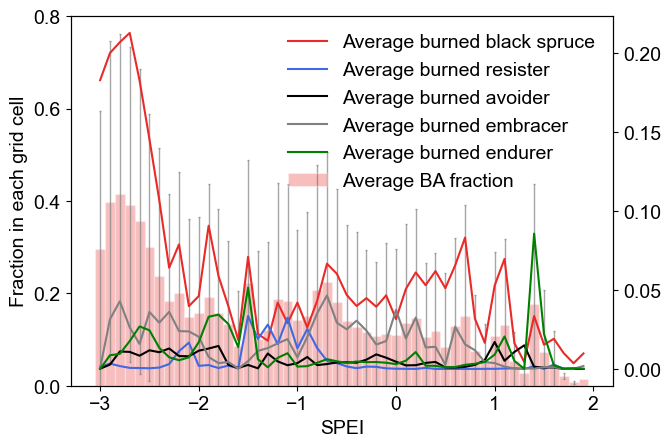

In [14]:
import xarray as xr
import piecewise_regression as pice
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.colors as colors


if __name__ == '__main__':
    df_23 = pd.read_csv('D:/Documents/outfile/spei_EBA_2023_os.csv')
    df_his = pd.read_csv('D:/Documents/outfile/spei_EBA_his_os.csv')
    # 合并两个dataframe
    df_all = pd.concat([df_23, df_his])


    spei = df_all['spei']
    EBA = df_all['EBA']
    BA = df_all['BA']
    Other_species = df_all['Other_species']
    Invader = df_all['Invader']
    resister = df_all['resister']
    avoider = df_all['avoider']
    embracer = df_all['embracer']
    endurer = df_all['endurer']


    # 对数据进行分组统计
    df_all['spei'] = pd.cut(df_all['spei'], bins=np.arange(-3, 2.1, 0.1))

   
    # 绘制不同spei区间的Other species均值
    X = np.arange(-3, 2, 0.1)
    Y_os = df_all.groupby('spei')['Other_species'].mean()
    Y_BA = df_all.groupby('spei')['BA'].mean()
    Y_Invader = df_all.groupby('spei')['Invader'].mean()
    Y_resister = df_all.groupby('spei')['resister'].mean()
    Y_avoider = df_all.groupby('spei')['avoider'].mean()    
    Y_BA_std = df_all.groupby('spei')['BA'].std()
    Y_EBA = df_all.groupby('spei')['EBA'].mean()
    Y_endurer = df_all.groupby('spei')['endurer'].mean()
    Y_embracer = df_all.groupby('spei')['embracer'].mean()

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap
    trunc_cmap = truncate_colormap(plt.get_cmap("Reds"), 0.2, 0.8)
    trunc_cmap1 = truncate_colormap(plt.get_cmap("Blues"), 0.2, 0.8)

    # 线性拟合
    #linear_fit_23 = np.polyfit(spei_23, EBA_23, 1)
    #linear_fit_his = np.polyfit(spei_ls_his, EBA_ls_his, 1)
    #y_values_23 = np.polyval(linear_fit_23, X_23)
    #y_values_his = np.polyval(linear_fit_his, X_his)

    # 字体字号，arial，14
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = 14
    
    # 1行2列
    fig, ax = plt.subplots(figsize=(7, 4.8))
    # 绘制密度散点图
    #sns.kdeplot(x=spei, y=Os_23, fill=True, cmap=trunc_cmap, alpha=0.5, ax=ax[0])
    #sns.kdeplot(x=spei_ls_his, y=Os_his, fill=True, cmap=trunc_cmap1, alpha=0.5, ax=ax[0])
    # 绘制中位数
    
    
    # 在底部绘制BA中位数的柱状图,bar宽度0.1
    # 设置errorbar 参数
    error_kw = {
        'ecolor': 'grey',        # 误差条颜色
        'elinewidth': 1,         # 误差条线宽
        'capsize': 0.5,            # 误差条帽子大小
        #'capthick': 2,           # 误差条帽子线宽
        'alpha': 0.7   
    }
    ax.bar(X, np.array(Y_BA), color='#E92A28', edgecolor='white', width=0.1, alpha=0.3, label='Average BA fraction', yerr = Y_BA_std, error_kw=error_kw)
    #ax[0].bar(X_his, np.array(Y_BA_his), color='#0F7AAC', edgecolor='white', width=0.1, alpha=0.5, label='Average BA fraction in 2020-2022')
    ax.set_ylabel('Fraction in each grid cell')
    ax.set_ylim(0, 0.8)
    # 设置ytick
    yticks = [0, 0.2, 0.4, 0.6, 0.8]
    ax.set_yticks(yticks)
    
    ax.set_xlabel('SPEI')

    # 次坐标轴
    ax2 = ax.twinx()
   # ax2.plot(X, Y_os, color='brown', linestyle='-', label='Average burned other species')
    ax2.plot(X, Y_EBA, color='#E92A28', linestyle='-', label='Average burned black spruce')
    ax2.plot(X, Y_resister, color='royalblue', linestyle='-', label='Average burned resister')
    ax2.plot(X, Y_avoider, color='black', linestyle='-', label='Average burned avoider')
    ax2.plot(X, Y_embracer, color='grey', linestyle='-', label='Average burned embracer')
    ax2.plot(X, Y_endurer, color='green', linestyle='-', label='Average burned endurer')

    ax.legend(loc='upper right', bbox_to_anchor=(0.85, 0.625), frameon=False)
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
    #ax2.plot(X_his, Y_his, color='grey', linestyle='-', label='Other species in 2020-2022')
    
    #ax2.plot(X_his, Y_his, color='grey', linestyle='-', label='Other species in 2020-2022')
    ''''''
    

    plt.savefig('D:/Documents/Fig/SPEI_species_compare_allspecies.png', dpi=300, bbox_inches='tight')
    

#### 历史情况

##### 历史火灾季节SPEI

[1989 1994 1995 1998 2006 2010 2011 2012 2013 2014 2015 2016 2017 2022
 2023]


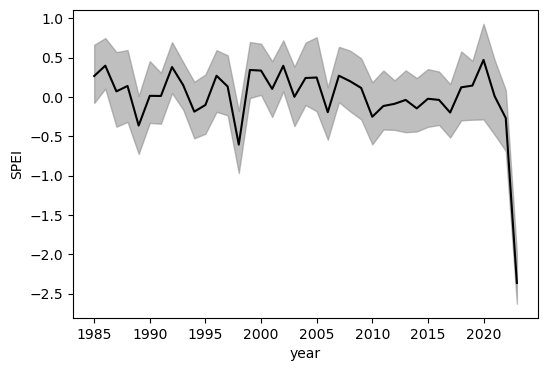

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rioxarray as rxr
import scipy.stats as stats
import pandas as pd
import seaborn as sns


if __name__ == '__main__':
    spei_Dir = "D:/ERA5/ERA5land_monthly_2000_2023_5eco_extent/spei_pro/spei_2402"
    spei_fn = "ERA5landn_climgrid_lowres_spei_5eco_spei_gamma_03.nc"
    spei_ds = xr.open_dataset(spei_Dir + "/" + spei_fn)
    spei_ds = spei_ds.sel(lat=spei_ds.lat[spei_ds.lat > 47])
    spei_da = spei_ds.spei_gamma_03
    spei_da = spei_da.sel(time=spei_da.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))
    # 求每年的均值
    spei_fs = spei_da.groupby('time.year').mean('time')

    # 计算spei_fs的空间median
    spei_median = spei_fs.median(dim=['lat', 'lon'])
    spei_median = spei_median.values
    # 计算spei_fs的空间quantile
    spei_p25 = spei_fs.quantile(0.25, dim=['lat', 'lon'])
    spei_p75 = spei_fs.quantile(0.75, dim=['lat', 'lon'])
    spei_p25 = spei_p25.values
    spei_p75 = spei_p75.values

    # plot
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(1985, 2024)
    plt.plot(x, spei_median, color='black')
    plt.fill_between(x, spei_p25, spei_p75, color='gray', alpha=0.5)
    plt.xlabel('year')
    plt.ylabel('SPEI')

    # 选取spei_median中小于0的年份
    idx_neg = np.where(spei_median < 0)
    year_neg = x[idx_neg]
    print(year_neg)
     

##### 根据选取出来的年份取数据

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rioxarray as rxr
import scipy.stats as stats
import pandas as pd
import seaborn as sns


if __name__ == '__main__':
    tar_year = ["1989", "1994", "1995", "1998", "2006", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

    EBA_Dir = "D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005"
    spei_Dir = "D:/ERA5/ERA5land_monthly_2000_2023_5eco_extent/spei_pro/spei_2402"
    BA_dir = "D:/wildfire/NBAC/NBAC_image_5eco_0005de"
    # 年份对应关系
    year_dict = {"1987": ["1988", "1989", "1990", "1991"],
                "1991": ["1992", "1993", "1994", "1995"],
                "1995": ["1996", "1997", "1998", "1999"],
                "1999": ["2000", "2001", "2002", "2003"],
                "2003": ["2004", "2005", "2006", "2007"],
                "2007": ["2008", "2009", "2010", "2011"],
                "2011": ["2012", "2013", "2014", "2015"],
                "2015": ["2016", "2017", "2018", "2019"],
                 }
    
    # 读取spei
    spei_fn = "ERA5landn_climgrid_lowres_spei_5eco_spei_gamma_03.nc"
    spei_ds = xr.open_dataset(spei_Dir + "/" + spei_fn)
    spei_ds = spei_ds.sel(lat=spei_ds.lat[spei_ds.lat > 47])
    spei_da = spei_ds.spei_gamma_03
    # 选取月份为4-10月的数据
    spei_da = spei_da.sel(time=spei_da.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))
    # 求每年的均值
    spei_fs = spei_da.groupby('time.year').mean('time')

    # 固定参数
    c_res = 0.1
    h_res = 0.005
    ratio = int(c_res/h_res)
    
    EBA_ls_his = []
    spei_ls_his = []
    BA_ls_his = []
    year_ls = []

    # 遍历year_dict
    for key in year_dict:
        print(key)
        print(year_dict[key])
        # 判断在year_dict[key]中的tar_year
        tar_year_ls = [i for i in year_dict[key] if i in tar_year]
        len_tar_year = len(tar_year_ls)
        if len_tar_year == 0:
            continue
        else:   
            print(str(len_tar_year) + " year in this group: " + key)
        
        # 获取EBA数据
        EBA_fn = "Canada_Tree_Species_Classification_HMM_" + key + "_EBA_WGS84_0005_5eco.tif"
        # 读取树种数据
        EBA_da = rxr.open_rasterio(EBA_Dir + "/" + EBA_fn)
        EBA_da_year =  EBA_da.squeeze()
        
        # 获取BA数据
        for seleced_year in tar_year_ls:
            BA_fn = "Clipped_NBAC_" + seleced_year + "_Image_mosaic_0005de.tif"
            BA_da = rxr.open_rasterio(BA_dir + "/" + BA_fn)
            BA_da_year = BA_da.squeeze()
            BA_da_year = BA_da_year.where(BA_da_year <= 0, 1)    
            # 获取spei数据
            spei_year = spei_fs.sel(year=int(seleced_year))
            spei_year = spei_year.values
            spei_rows = spei_year.shape[0]
            spei_cols = spei_year.shape[1]
            print(spei_rows, spei_cols)

            # 遍历每个像元
            for i in range(spei_rows):
                for j in range(spei_cols):
                    # spei23的值
                    spei_value = spei_year[i, j]
                    # 获取高分辨率数据范围
                    EBA_cell = EBA_da_year[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
                    BA_cell = BA_da_year[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values

                    # 判断这个格点是否出现过火灾
                    if BA_cell.max() > 0:
                        # 筛选出该格点中发生火灾的位置的EBA值
                        EBA_1d = EBA_cell.flatten()
                        EBA_1d = EBA_1d[BA_cell.flatten() > 0]
                        # 删除nan值
                        EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                        # 统计总的BA fraction
                        cell_BA_fraction = BA_cell.flatten()
                        cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                        cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                        # 统计火灾个店内的EBA fraction
                        cell_EBA_fraction = EBA_1d.flatten()
                        cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                        # 添加到列表中
                        EBA_ls_his.append(cell_EBA_fraction)
                        spei_ls_his.append(spei_value)
                        BA_ls_his.append(cell_BA_fraction)
                        year_ls.append(seleced_year)
   
    # 将列表转换为数组
    EBA_ls_his = np.array(EBA_ls_his)
    spei_ls_his = np.array(spei_ls_his)
    BA_ls_his = np.array(BA_ls_his)
    year_ls = np.array(year_ls)
    
    # 输出是否存在nan值
    print(np.isnan(EBA_ls_his).any())
    print(np.isnan(spei_ls_his).any())
    print(np.isnan(BA_ls_his).any())

    # 剔除nan值
    EBA_ls_his = EBA_ls_his[~np.isnan(spei_ls_his)]
    BA_ls_his = BA_ls_his[~np.isnan(spei_ls_his)]
    year_ls = year_ls[~np.isnan(spei_ls_his)]
    spei_ls_his = spei_ls_his[~np.isnan(spei_ls_his)]

    # 创建dataframe
    df_his = pd.DataFrame({'EBA': EBA_ls_his, 'spei': spei_ls_his, 'BA': BA_ls_his, 'year': year_ls})
    # save as csv
    df_his.to_csv('D:/Documents/Fig/spei_EBA_BA_1985_2019.csv', index=False)

    # 关闭所有数据库
    spei_ds.close()
    EBA_da.close()
    BA_da.close()
    print('done!')

1987
['1988', '1989', '1990', '1991']
1 year in this group: 1987
230 865
1991
['1992', '1993', '1994', '1995']
2 year in this group: 1991
230 865
230 865
1995
['1996', '1997', '1998', '1999']
1 year in this group: 1995
230 865
1999
['2000', '2001', '2002', '2003']
2003
['2004', '2005', '2006', '2007']
1 year in this group: 2003
230 865
2007
['2008', '2009', '2010', '2011']
2 year in this group: 2007
230 865
230 865
2011
['2012', '2013', '2014', '2015']
4 year in this group: 2011
230 865
230 865
230 865
230 865
2015
['2016', '2017', '2018', '2019']
2 year in this group: 2015
230 865
230 865
False
True
False
done!


##### 提取年份逐年绘图

C:\Users\Administrator\AppData\Local\Temp\ipykernel_39160\982362077.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['spei'] = pd.cut(df_year['spei'], bins=np.arange(-2, 2.1, 0.1))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_39160\982362077.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_EBA = df_year.groupby('spei')['EBA'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_39160\982362077.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

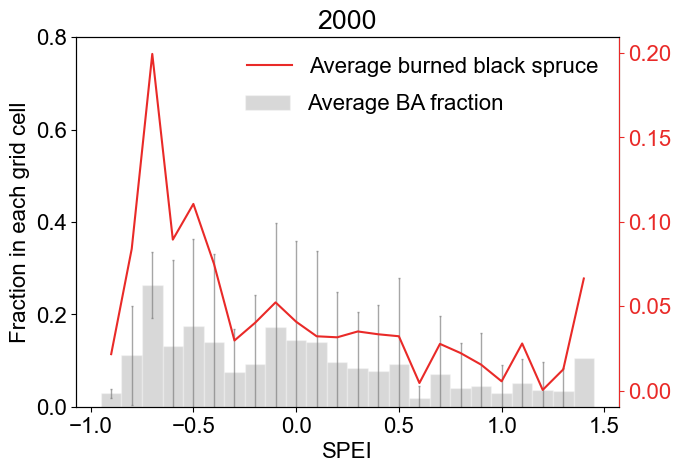

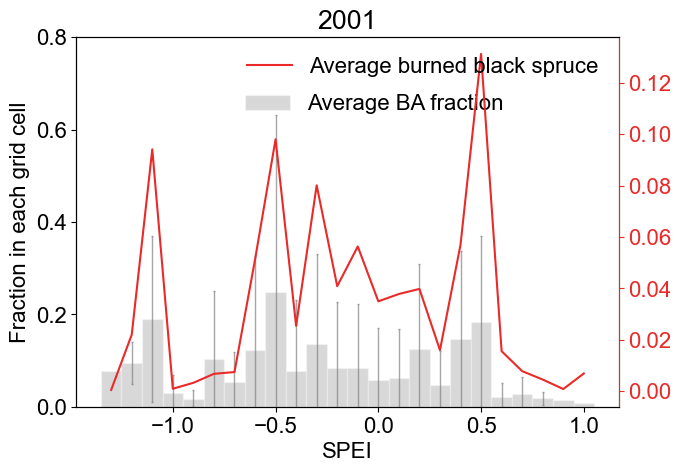

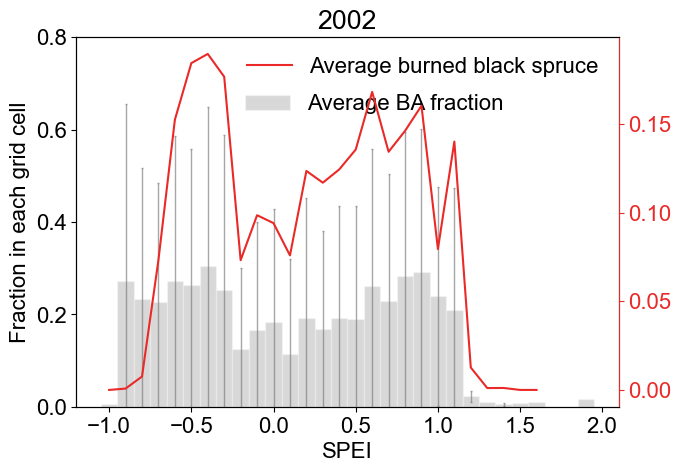

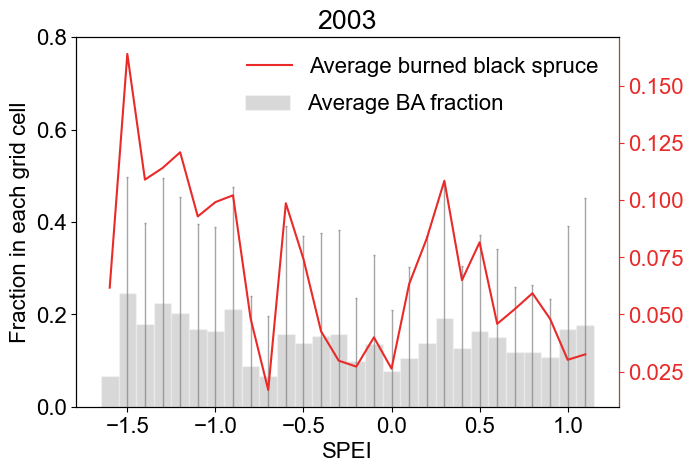

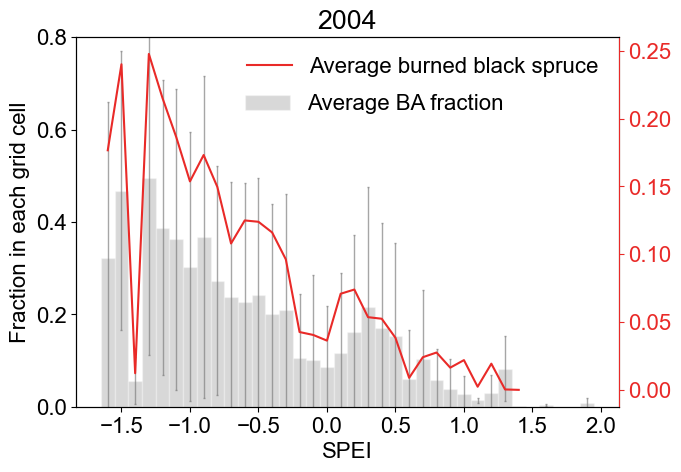

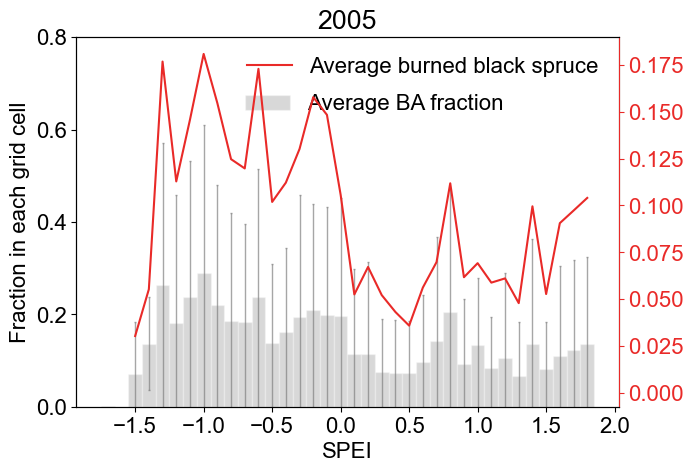

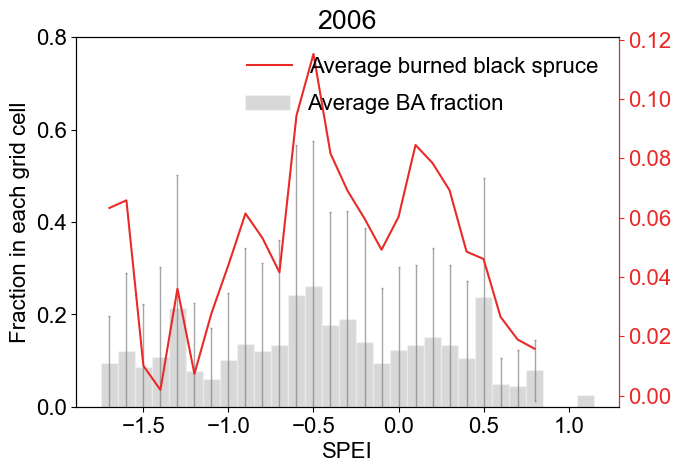

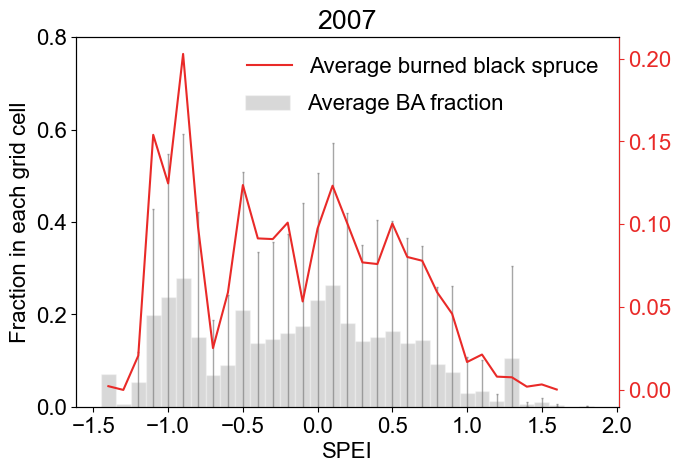

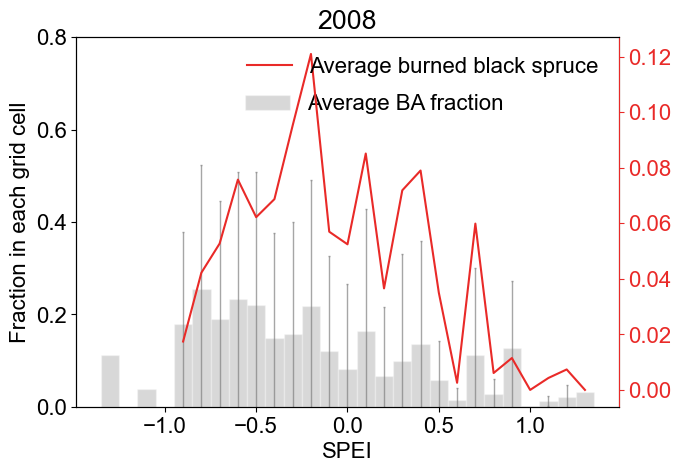

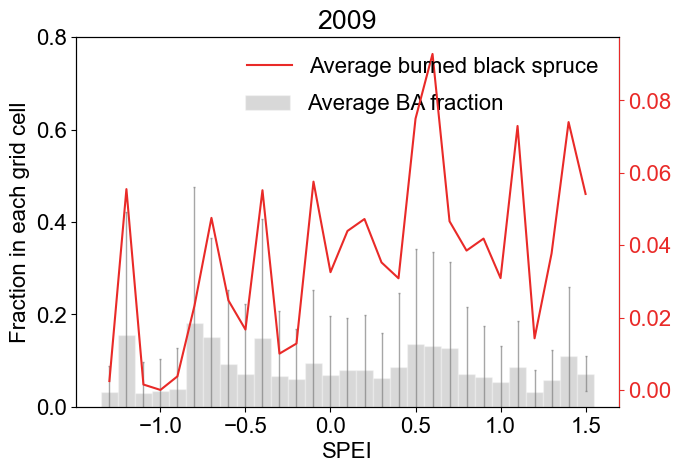

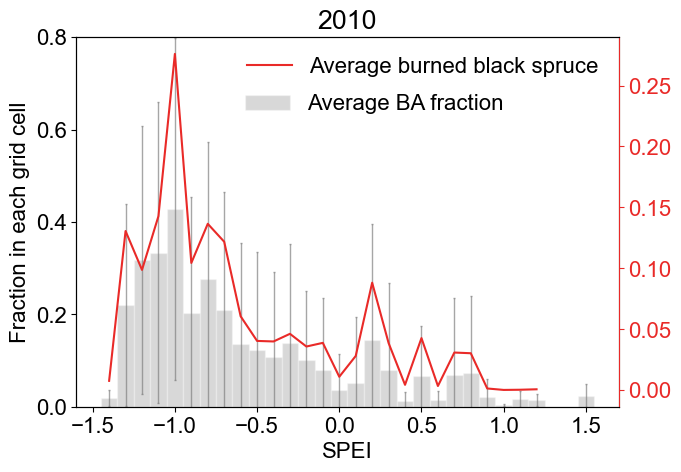

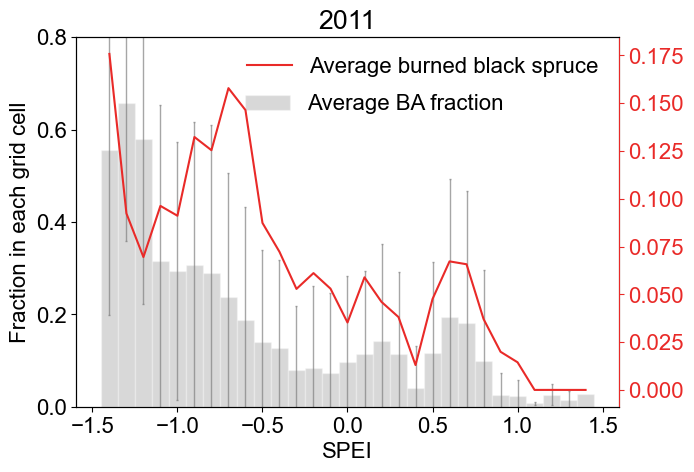

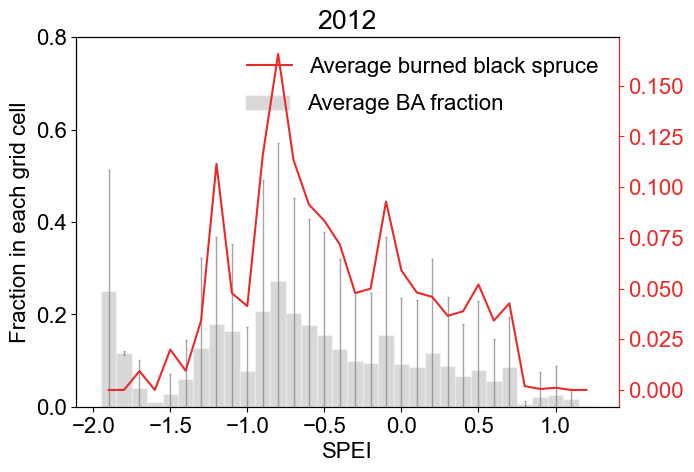

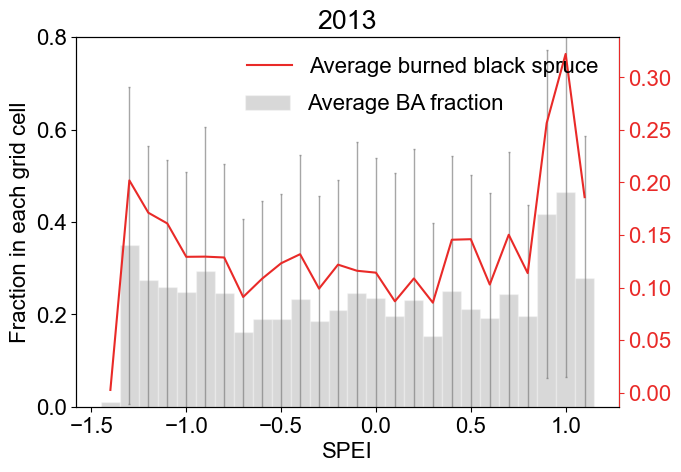

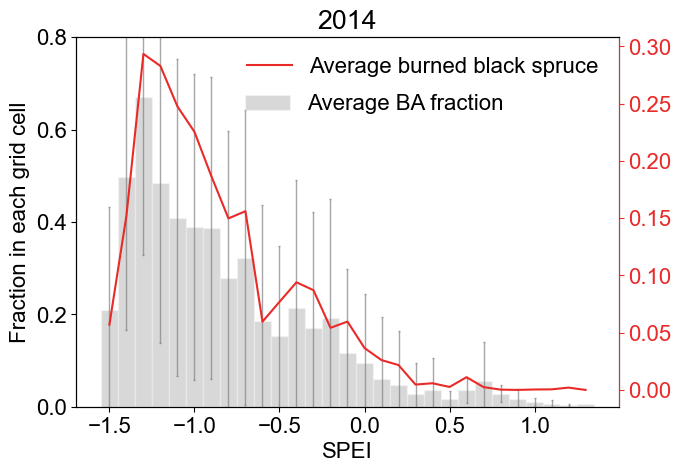

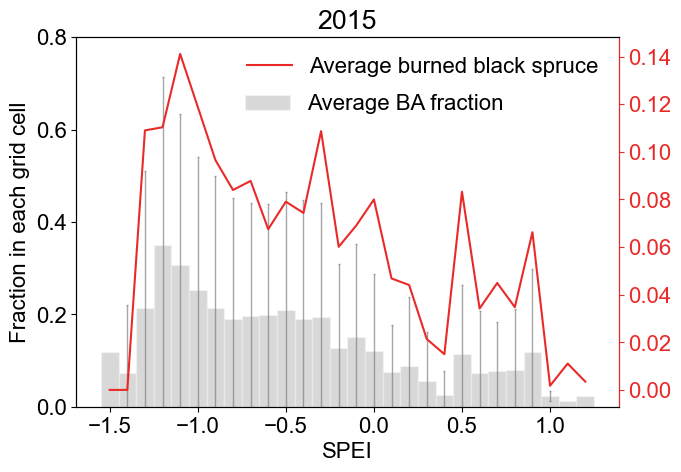

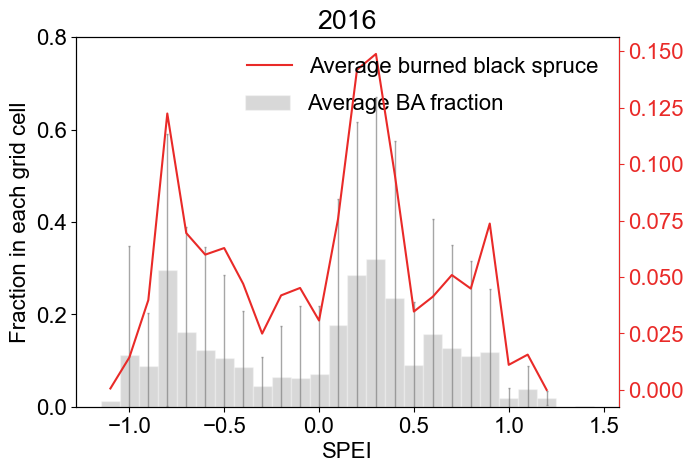

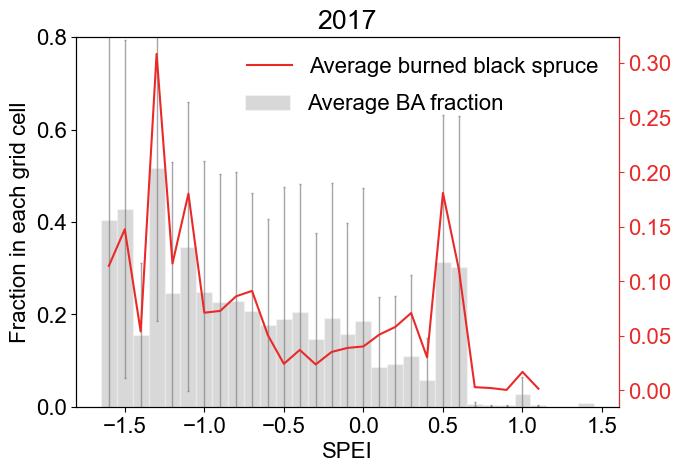

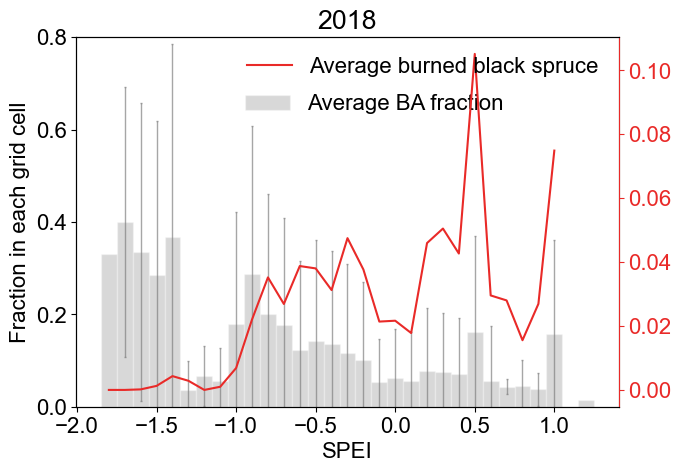

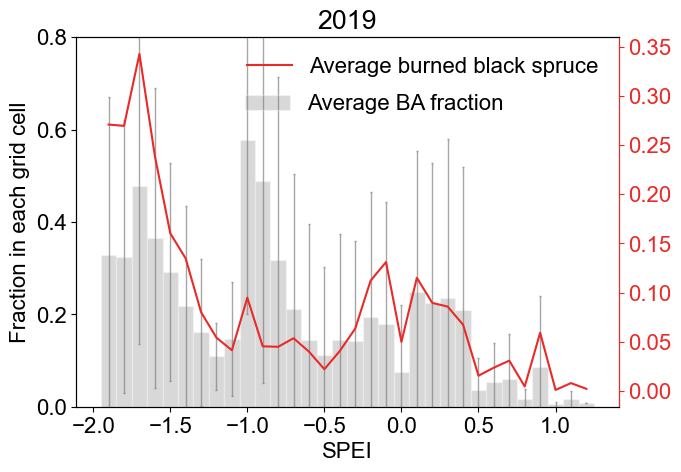

In [20]:
import xarray as xr
import piecewise_regression as pice
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.colors as colors


if __name__ == '__main__':
    df = pd.read_csv('D:/Documents/outfile/spei_EBA_BA_2000_2019.csv')
    df = df.dropna()
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = 16

    years = df['year'].unique()
    for year in years:
        # 选取df中year列在value_ls中的数据
        df_year = df[df['year'] == year]

        spei = df_year['spei']
        EBA = df_year['EBA']
        BA = df_year['BA']
        # 对数据进行分组统计
        df_year['spei'] = pd.cut(df_year['spei'], bins=np.arange(-2, 2.1, 0.1))
        
        # 绘制不同spei区间的species均值
        X = np.arange(-2, 2, 0.1)
        Y_EBA = df_year.groupby('spei')['EBA'].mean()
        Y_BA = df_year.groupby('spei')['BA'].mean()
        Y_EBA_std = df_year.groupby('spei')['EBA'].std()
        Y_BA_std = df_year.groupby('spei')['BA'].std()
        

        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            new_cmap = colors.LinearSegmentedColormap.from_list(
                "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap
        trunc_cmap = truncate_colormap(plt.get_cmap("Reds"), 0.2, 0.8)
        trunc_cmap1 = truncate_colormap(plt.get_cmap("Blues"), 0.2, 0.8)

        # 1行2列
        fig, ax = plt.subplots(figsize=(7, 4.8))       
        
        # 在底部绘制BA中位数的柱状图,bar宽度0.1
        # 设置errorbar 参数
        error_kw = {
            'ecolor': 'grey',        # 误差条颜色
            'elinewidth': 1,         # 误差条线宽
            'capsize': 0.5,            # 误差条帽子大小
            #'capthick': 2,           # 误差条帽子线宽
            'alpha': 0.7   
        }

        ax.bar(X, np.array(Y_BA), color='gray', edgecolor='white', width=0.1, alpha=0.3, label='Average BA fraction', yerr = Y_BA_std, error_kw=error_kw)
        #ax[0].bar(X_his, np.array(Y_BA_his), color='#0F7AAC', edgecolor='white', width=0.1, alpha=0.5, label='Average BA fraction in 2020-2022')
        ax.set_ylabel('Fraction in each grid cell')
        ax.set_ylim(0, 0.8)
        # 设置ytick
        yticks = [0, 0.2, 0.4, 0.6, 0.8]
        ax.set_yticks(yticks)
        
        ax.set_xlabel('SPEI')
        ax.set_title(year)

        # 次坐标轴
        ax2 = ax.twinx()
        # 次坐标轴y轴颜色
        ax2.spines['right'].set_color('#E92A28')
        # 设置次坐标轴ytick颜色
        ax2.tick_params(axis='y', colors='#E92A28')
        ax2.plot(X, Y_EBA, color='#E92A28', linestyle='-', label='Average burned black spruce')
        ax.legend(loc='upper right', bbox_to_anchor=(0.825, 0.9), frameon=False)
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

##### 历史数据

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rioxarray as rxr
import scipy.stats as stats
import pandas as pd
import seaborn as sns


if __name__ == '__main__':
    EBA_Dir = "D:/Landcover/CA_forest_lead_tree_species/wildfire_clip_0005"
    spei_Dir = "D:/ERA5/ERA5land_monthly_2000_2023_5eco_extent/spei_pro/spei_2402"
    BA_dir = "D:/wildfire/NBAC/NBAC_image_5eco_0005de"

    # 读取spei
    spei_fn = "ERA5landn_climgrid_lowres_spei_5eco_spei_gamma_03.nc"
    spei_ds = xr.open_dataset(spei_Dir + "/" + spei_fn)
    spei_ds = spei_ds.sel(lat=spei_ds.lat[spei_ds.lat > 47])
    spei_da = spei_ds.spei_gamma_03
    # 选取月份为4-10月的数据
    spei_da = spei_da.sel(time=spei_da.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))
    # 求每年的均值
    spei_fs = spei_da.groupby('time.year').mean('time')

    # 建立年份对应关系
    year_dict = {"1999": ["2000", "2001", "2002", "2003"],
                "2003": ["2004", "2005", "2006", "2007"],
                "2007": ["2008", "2009", "2010","2010", "2011"],
                "2011": ["2012", "2013", "2014", "2015"],
                "2015": ["2016", "2017", "2018", "2019"],
                 }
    # 固定参数
    c_res = 0.1
    h_res = 0.005
    ratio = int(c_res/h_res)
    
    EBA_ls_his = []
    spei_ls_his = []
    BA_ls_his = []
    year_ls = []

    # 遍历year_dict
    for key in year_dict:
        print(key)
        # 获取EBA数据
        EBA_fn = "Canada_Tree_Species_Classification_HMM_" + key + "_EBA_WGS84_0005_5eco.tif"
        # 读取树种数据
        EBA_da = rxr.open_rasterio(EBA_Dir + "/" + EBA_fn)
        EBA_da_year =  EBA_da.squeeze()
        value_ls = year_dict[key]
        for value in value_ls:
            BA_fn = "Clipped_NBAC_" + value + "_Image_mosaic_0005de.tif"
            BA_da = rxr.open_rasterio(BA_dir + "/" + BA_fn)
            BA_da_year = BA_da.squeeze()
            BA_da_year = BA_da_year.where(BA_da_year <= 0, 1)            
            # 获取value对应年份的spei
            spei_year_fs = spei_fs.sel(year=np.int16(value))
            # 打印spei_year_fs，BA_da_year和EBA_da_year的shape
            # print(spei_year_fs.shape, BA_da_year.shape, EBA_da_year.shape)
            spei_rows = spei_year_fs.shape[0]
            spei_cols = spei_year_fs.shape[1]
            print(spei_rows, spei_cols)
            
            # 遍历对应年份的所有格点
            for i in range(spei_rows):
                for j in range(spei_cols):
                    # BA cell
                    BA_cell = BA_da_year[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values

                    # 判断这个格点是否出现过火灾
                    if BA_cell.max() > 0:
                        spei_value = spei_year_fs[i, j].values
                        EBA_cell = EBA_da_year[i*ratio:i*ratio+ratio, j*ratio:j*ratio+ratio].values
                        # 筛选出该格点中发生火灾的位置的EBA值
                        EBA_1d = EBA_cell.flatten()
                        EBA_1d = EBA_1d[BA_cell.flatten() > 0]
                        # 删除nan值
                        EBA_1d = EBA_1d[~np.isnan(EBA_1d)]
                        # 统计总的BA fraction
                        cell_BA_fraction = BA_cell.flatten()
                        cell_BA_fraction = cell_BA_fraction[cell_BA_fraction > 0]
                        cell_BA_fraction = np.sum(cell_BA_fraction)/ratio**2
                        # 统计火灾个店内的EBA fraction
                        cell_EBA_fraction = EBA_1d.flatten()
                        cell_EBA_fraction = np.sum(cell_EBA_fraction)/ratio**2
                        # 添加到列表中
                        EBA_ls_his.append(cell_EBA_fraction)
                        spei_ls_his.append(spei_value)
                        BA_ls_his.append(cell_BA_fraction)
                        year_ls.append(int(value))
    # 将列表转换为数组
    EBA_ls_his = np.array(EBA_ls_his)
    spei_ls_his = np.array(spei_ls_his)
    BA_ls_his = np.array(BA_ls_his)
    year_ls = np.array(year_ls)
    
    # 输出是否存在nan值
    print(np.isnan(EBA_ls_his).any())
    print(np.isnan(spei_ls_his).any())
    print(np.isnan(BA_ls_his).any())

    # 剔除nan值
    EBA_ls_his = EBA_ls_his[~np.isnan(spei_ls_his)]
    BA_ls_his = BA_ls_his[~np.isnan(spei_ls_his)]
    year_ls = year_ls[~np.isnan(spei_ls_his)]
    spei_ls_his = spei_ls_his[~np.isnan(spei_ls_his)]

    # 创建dataframe
    df_his = pd.DataFrame({'EBA': EBA_ls_his, 'spei': spei_ls_his, 'BA': BA_ls_his, 'year': year_ls})
    # save as csv
    df_his.to_csv('D:/Documents/Fig/spei_EBA_BA_2000_2019.csv', index=False)

    # 关闭所有数据库
    spei_ds.close()
    EBA_da.close()
    BA_da.close()
    print('done!')

KeyboardInterrupt: 

##### 历史数据绘图

1999
2003
2007
2011


C:\Users\Administrator\AppData\Local\Temp\ipykernel_532\4187241770.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['spei'] = pd.cut(df_year['spei'], bins=np.arange(-2, 2.1, 0.1))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_532\4187241770.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_EBA = df_year.groupby('spei')['EBA'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_532\4187241770.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

2015


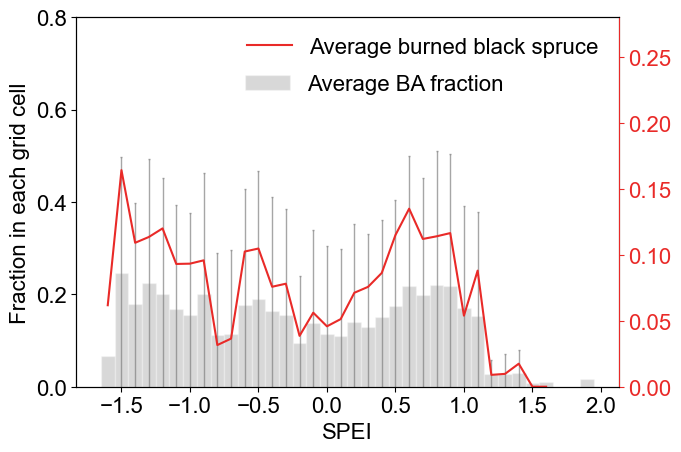

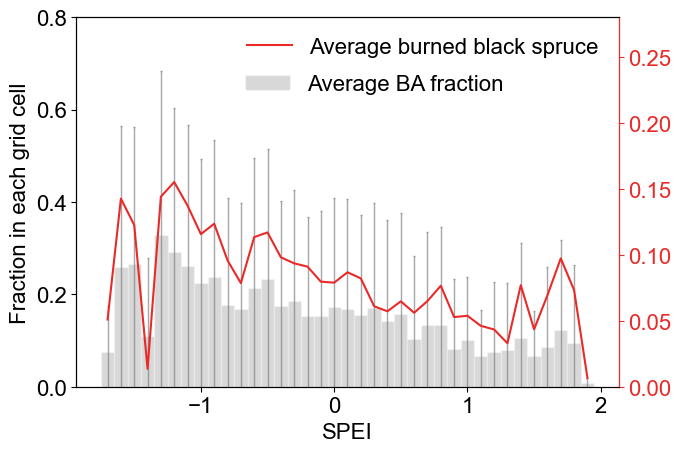

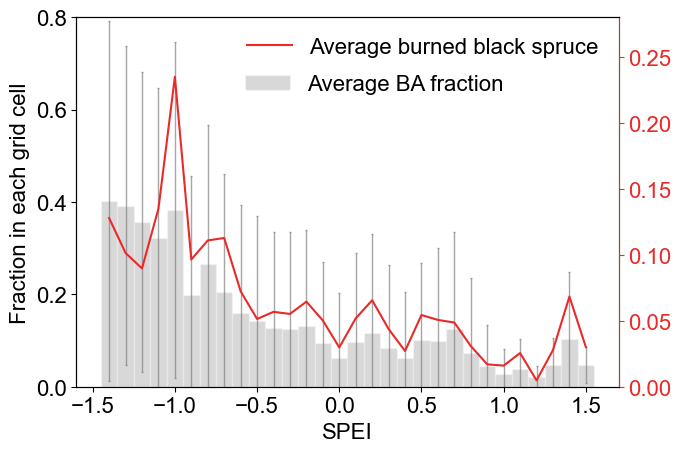

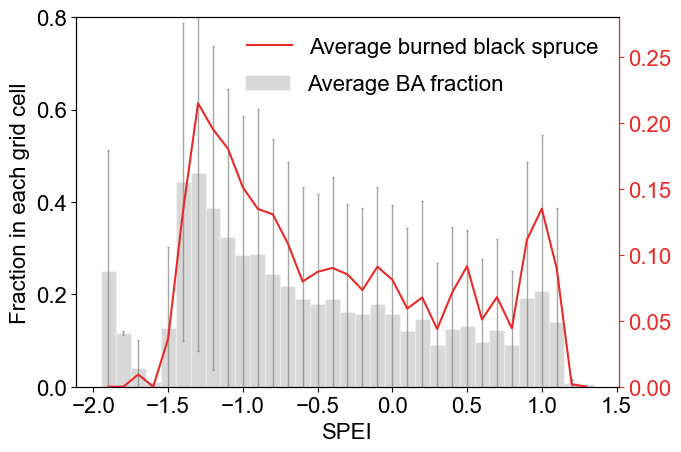

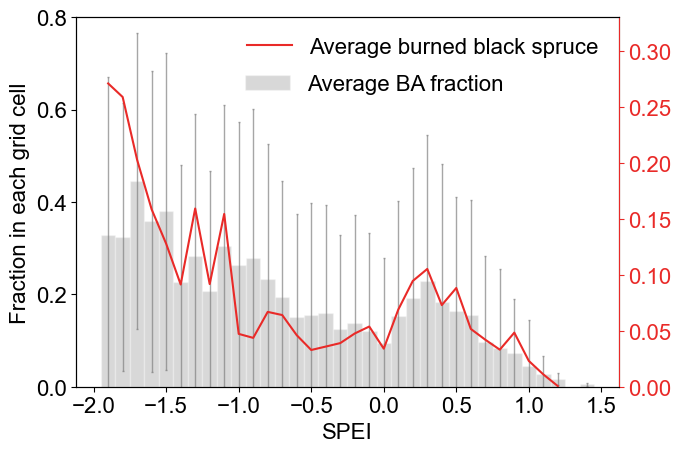

In [ ]:
import xarray as xr
import piecewise_regression as pice
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib.colors as colors


if __name__ == '__main__':
    df = pd.read_csv('D:/Documents/outfile/spei_EBA_BA_2000_2019.csv')
  
    
    # 建立年份对应关系
    year_dict = {"1999": ["2000", "2001", "2002", "2003"],
                "2003": ["2004", "2005", "2006", "2007"],
                "2007": ["2008", "2009", "2010", "2011"],
                "2011": ["2012", "2013", "2014", "2015"],
                "2015": ["2016", "2017", "2018", "2019"],
                 }
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.size'] = 16

    # 遍历year_dict
    for key in year_dict:
        year_key = int(key)
        print(key)
        value_ls = year_dict[key]
        # 转为int
        value_ls = [int(i) for i in value_ls]
        min_value = min(value_ls)
        max_value = max(value_ls)
        # 选取df中year列在value_ls中的数据
        df_year = df[df['year'].isin(value_ls)]
    
        spei = df_year['spei']
        EBA = df_year['EBA']
        BA = df_year['BA']
        # 对数据进行分组统计
        df_year['spei'] = pd.cut(df_year['spei'], bins=np.arange(-2, 2.1, 0.1))
        
        # 绘制不同spei区间的species均值
        X = np.arange(-2, 2, 0.1)
        Y_EBA = df_year.groupby('spei')['EBA'].mean()
        Y_BA = df_year.groupby('spei')['BA'].mean()
        Y_EBA_std = df_year.groupby('spei')['EBA'].std()
        Y_BA_std = df_year.groupby('spei')['BA'].std()
        

        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            new_cmap = colors.LinearSegmentedColormap.from_list(
                "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap
        trunc_cmap = truncate_colormap(plt.get_cmap("Reds"), 0.2, 0.8)
        trunc_cmap1 = truncate_colormap(plt.get_cmap("Blues"), 0.2, 0.8)

        # 1行2列
        fig, ax = plt.subplots(figsize=(7, 4.8))
        # 绘制密度散点图
        #sns.kdeplot(x=spei, y=Os_23, fill=True, cmap=trunc_cmap, alpha=0.5, ax=ax[0])
        #sns.kdeplot(x=spei_ls_his, y=Os_his, fill=True, cmap=trunc_cmap1, alpha=0.5, ax=ax[0])
        # 绘制中位数
        
        
        # 在底部绘制BA中位数的柱状图,bar宽度0.1
        # 设置errorbar 参数
        error_kw = {
            'ecolor': 'grey',        # 误差条颜色
            'elinewidth': 1,         # 误差条线宽
            'capsize': 0.5,            # 误差条帽子大小
            #'capthick': 2,           # 误差条帽子线宽
            'alpha': 0.7   
        }

        ax.bar(X, np.array(Y_BA), color='gray', edgecolor='white', width=0.1, alpha=0.3, label='Average BA fraction', yerr = Y_BA_std, error_kw=error_kw)
        #ax[0].bar(X_his, np.array(Y_BA_his), color='#0F7AAC', edgecolor='white', width=0.1, alpha=0.5, label='Average BA fraction in 2020-2022')
        ax.set_ylabel('Fraction in each grid cell')
        ax.set_ylim(0, 0.8)
        # 设置ytick
        yticks = [0, 0.2, 0.4, 0.6, 0.8]
        ax.set_yticks(yticks)
        
        ax.set_xlabel('SPEI')

        # 次坐标轴
        ax2 = ax.twinx()
        # 次坐标轴y轴颜色
        ax2.spines['right'].set_color('#E92A28')
        # 设置次坐标轴ytick颜色
        ax2.tick_params(axis='y', colors='#E92A28')
        ax2.plot(X, Y_EBA, color='#E92A28', linestyle='-', label='Average burned black spruce')
        ax.legend(loc='upper right', bbox_to_anchor=(0.825, 0.9), frameon=False)
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

        if year_key == 1999 or year_key == 2003:
            # ax2 yticks设置为0-0.2
            yticks = [0, 0.05, 0.1, 0.15, 0.2]
            ax2.set_yticks(yticks)
            ax2.set_ylim(0, 0.23)
        if year_key == 2007 or 2011:
            # ax2 yticks设置为0-0.4
            yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
            ax2.set_yticks(yticks)
            ax2.set_ylim(0, 0.28)
        if year_key == 2015:
            # ax2 yticks设置为0-0.6
            yticks = [0,0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
            ax2.set_yticks(yticks)
            ax2.set_ylim(0, 0.33)